## User Engagement Analysis

### Major Objectives 
Track the user’s engagement using the following engagement metrics: 
- sessions frequency 
- the duration of the session 
- the sessions total traffic (download and upload (bytes))

### Sub Tasks
- Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 
- Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 
- Compute the minimum, maximum, average & total non- normalized metrics for each cluster. 
- Interpret your results visually with accompanying text explaining your findings.
- Aggregate user total traffic per application and derive the top 10 most engaged users per application
- Plot the top 3 most used applications using appropriate charts.  
- Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: 
- What is the optimized value of k (use elbow method for this)?  
- Interpret your findings. 


### Importing Liberaries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from plotly.subplots import make_subplots
from scipy.stats import zscore
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist

import matplotlib
import warnings
import plotly.io as pio
warnings.filterwarnings("ignore", category=FutureWarning)
import math
from IPython.display import Image
import sys, os

In [45]:
sys.path.append(os.path.abspath(os.path.join('../scripts..')))
from data_visualizer import *
from data_selector import *
from outlier_handler import OutlierHandler
#from outlier_handler import OutlierHandler

### Load Data

In [46]:
clean_df = pd.read_csv("../data/my_clean_data.csv")
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 55 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        146887 non-null  int64  
 1   Bearer Id                         146887 non-null  int64  
 2   Start                             146887 non-null  object 
 3   Start ms                          146887 non-null  float64
 4   End                               146887 non-null  object 
 5   End ms                            146887 non-null  float64
 6   IMSI                              146887 non-null  int64  
 7   MSISDN/Number                     146887 non-null  int64  
 8   IMEI                              146887 non-null  int64  
 9   Last Location Name                146887 non-null  object 
 10  Avg RTT DL (ms)                   146887 non-null  float64
 11  Avg RTT UL (ms)                   146887 non-null  f

In [94]:
float64_cols = clean_df.select_dtypes(include='int64').columns
clean_df[float64_cols] = clean_df[float64_cols].astype('float32')


In [95]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 55 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        146887 non-null  float32
 1   Bearer Id                         146887 non-null  float32
 2   Start                             146887 non-null  object 
 3   Start ms                          146887 non-null  float32
 4   End                               146887 non-null  object 
 5   End ms                            146887 non-null  float32
 6   IMSI                              146887 non-null  float32
 7   MSISDN/Number                     146887 non-null  float32
 8   IMEI                              146887 non-null  float32
 9   Last Location Name                146887 non-null  object 
 10  Avg RTT DL (ms)                   146887 non-null  float32
 11  Avg RTT UL (ms)                   146887 non-null  f

### User Engagement Analysis

**1. Top 10 customers per engagement metric**

In [96]:
total_users = clean_df['MSISDN/Number'].nunique()
print("The total number of Customer in the TellCo are = ",total_users)

The total number of Customer in the TellCo are =  34910


In [97]:
engagement_of_users = clean_df[['MSISDN/Number', 'Bearer Id', 'Dur. (ms).1', 'Total Data Volume (Bytes)']].copy().rename(columns={'Dur. (ms).1': 'time_duration'})#, 'total_data': 'total_data_volume'})
engagement_of_users

,MSISDN/Number,Bearer Id,time_duration,Total Data Volume (Bytes)
0,3.366496e+10,-9.223372e+18,245108160.0,345629376.0
1,3.368185e+10,-9.223372e+18,245108160.0,707185344.0
2,3.376063e+10,-9.223372e+18,245108160.0,307690976.0
3,3.375034e+10,-9.223372e+18,245108160.0,889352768.0
4,3.369979e+10,-9.223372e+18,245108160.0,607681408.0
...,...,...,...,...
146882,3.376215e+10,7.349883e+18,61661728.0,352656000.0
146883,3.376127e+10,-9.223372e+18,84940608.0,116264912.0
146884,3.362611e+10,-9.223372e+18,125622432.0,666947456.0
146885,3.364566e+10,-9.223372e+18,113545184.0,922173952.0


In [98]:
user_engagements = engagement_of_users.groupby(
    'MSISDN/Number').agg({'Bearer Id': 'count', 'time_duration': 'sum', 'Total Data Volume (Bytes)': 'sum'})
user_engagements = user_engagements.rename(
    columns={'Bearer Id': 'user_sessions'})
user_engagements.head(5)

,user_sessions,time_duration,Total Data Volume (Bytes)
MSISDN/Number,,,
3.360100e+10,2,297951104.0,1.035550e+09
3.360100e+10,1,134969376.0,5.959665e+08
3.360101e+10,3,86982480.0,1.879732e+09
3.360101e+10,2,253983072.0,6.152172e+08
3.360101e+10,3,214760496.0,9.858016e+08


In [99]:
#top 10 user Engagements relative to time
user_engagements.nlargest(10, 'time_duration')

,user_sessions,time_duration,Total Data Volume (Bytes)
MSISDN/Number,,,
3.376161e+10,66,6.414072e+09,3.592171e+10
3.365936e+10,37,4.984168e+09,1.939380e+10
3.376167e+10,28,4.683296e+09,1.532960e+10
3.366186e+10,36,4.462327e+09,1.655583e+10
3.361489e+10,22,4.433479e+09,1.118957e+10
3.365973e+10,25,4.317239e+09,1.137677e+10
3.362578e+10,18,4.224774e+09,8.773197e+09
3.369937e+10,34,4.186565e+09,1.576996e+10
3.376161e+10,37,4.104306e+09,1.536807e+10


In [100]:
#top 10 user Engagements relative to time
user_engagements.nlargest(10, 'user_sessions')

,user_sessions,time_duration,Total Data Volume (Bytes)
MSISDN/Number,,,
3.376161e+10,66,6.414072e+09,3.592171e+10
3.376121e+10,39,3.759636e+09,1.965588e+10
3.365936e+10,37,4.984168e+09,1.939380e+10
3.376161e+10,37,4.104306e+09,1.536807e+10
3.366186e+10,36,4.462327e+09,1.655583e+10
3.376359e+10,35,3.634345e+09,1.648555e+10
3.369937e+10,34,4.186565e+09,1.576996e+10
3.365807e+10,33,3.816743e+09,1.872382e+10
3.365849e+10,33,2.842504e+09,1.815898e+10


In [101]:
#top 10 user Engagements relative to time
user_engagements.nlargest(10, 'Total Data Volume (Bytes)')

,user_sessions,time_duration,Total Data Volume (Bytes)
MSISDN/Number,,,
3.376161e+10,66,6.414072e+09,3.592171e+10
3.376121e+10,39,3.759636e+09,1.965588e+10
3.365936e+10,37,4.984168e+09,1.939380e+10
3.365807e+10,33,3.816743e+09,1.872382e+10
3.365849e+10,33,2.842504e+09,1.815898e+10
3.376375e+10,30,2.736850e+09,1.695484e+10
3.365097e+10,30,2.870921e+09,1.695480e+10
3.366186e+10,36,4.462327e+09,1.655583e+10
3.365895e+10,30,3.301885e+09,1.653727e+10


In [102]:
def mult_hist(sr, rows, cols, title_text, subplot_titles, interactive=False):
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)
    for i in range(rows):
        for j in range(cols):
            x = ["-> " + str(i) for i in sr[i+j].index]
            fig.add_trace(go.Bar(x=x, y=sr[i+j].values), row=i+1, col=j+1)
    fig.update_layout(showlegend=False, title_text=title_text)
    if(interactive):
        fig.show()
    else:
        return Image(pio.to_image(fig, format='png', width=1200))


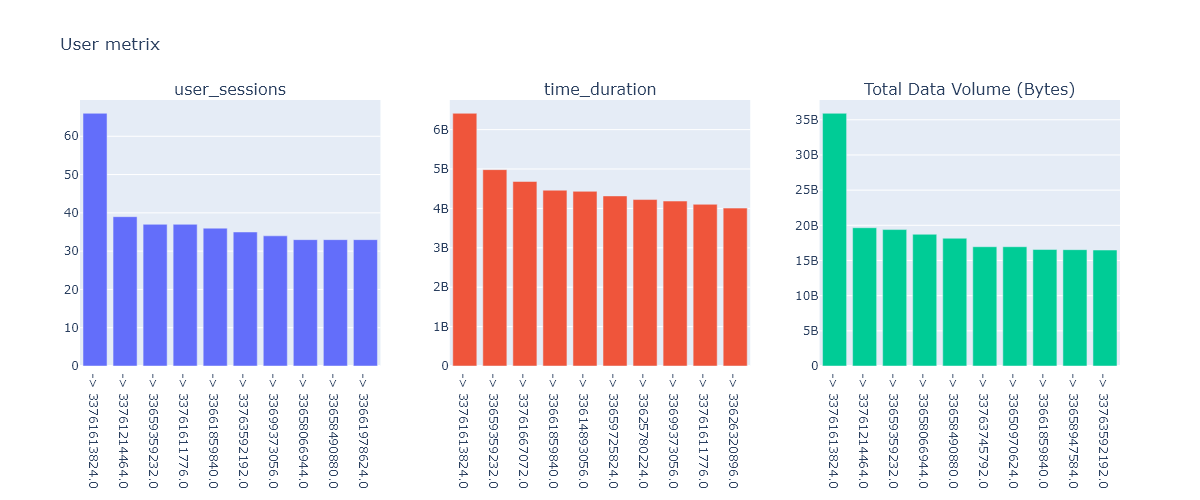

In [103]:
sessions = user_engagements.nlargest(10, "user_sessions")['user_sessions']
duration = user_engagements.nlargest(10, "time_duration")['time_duration']
total_data_volume = user_engagements.nlargest(10, "Total Data Volume (Bytes)")['Total Data Volume (Bytes)']

mult_hist([sessions, duration, total_data_volume], 1,3, "User metrix", ['user_sessions', 'time_duration','Total Data Volume (Bytes)'])

In [104]:
#Check for outliers

In [105]:
#pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org kaleido -vvv
#!pip install --upgrade "kaleido==0.1.*"

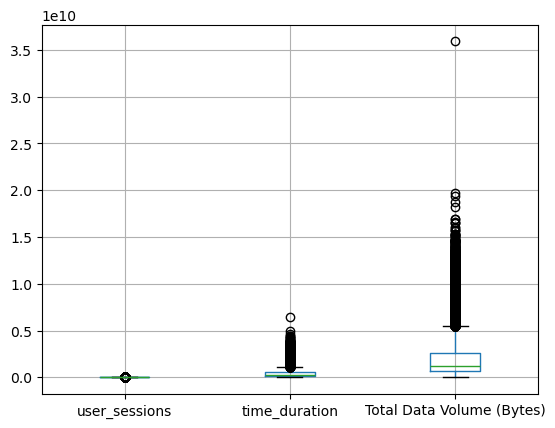

In [106]:
user_engagements.boxplot()
plt.show()

In [107]:
df_outliers = OutlierHandler(user_engagements)

In [108]:
df_outliers.getOverview(['user_sessions','time_duration','Total Data Volume (Bytes)'])

Name of columns,Total Data Volume (Bytes),time_duration,user_sessions
Min,37929240.0,7327634.0,1.0
Q1,628894000.0,107019412.0,1.0
Median,1173809600.0,229900880.0,2.0
Q3,2560850112.0,524928104.0,5.0
Max,35921711104.0,6414072320.0,66.0
IQR,1931956112.0,417908692.0,4.0
Lower fence,-2269040168.0,-519843626.0,-5.0
Upper fence,5458784280.0,1151791142.0,11.0
Skew,2.16266,2.317228,2.147985
Number_of_outliers,3484,3285,3189


- Outliers are presented in all metrics but they are not very skewed

In [109]:
df_outliers.replace_outliers_with_fences(
    ['user_sessions', 'time_duration', 'Total Data Volume (Bytes)'])
df_outliers.getOverview(['user_sessions','time_duration','Total Data Volume (Bytes)'])

Name of columns,user_sessions,time_duration,Total Data Volume (Bytes)
Min,1.0,7327634.0,37929240.0
Q1,1.0,107019412.0,628894000.0
Median,2.0,229900880.0,1173809600.0
Q3,5.0,524928104.0,2560850112.0
Max,11.0,1151791104.0,5458784256.0
IQR,4.0,417908692.0,1931956112.0
Lower fence,-5.0,-519843626.0,-2269040168.0
Upper fence,11.0,1151791142.0,5458784280.0
Skew,1.187218,1.142333,1.124282
Number_of_outliers,0,0,0


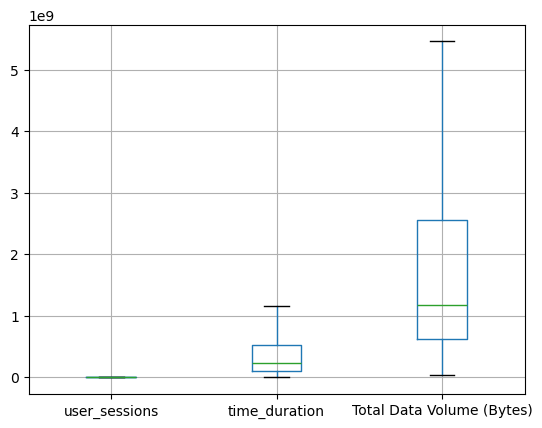

In [110]:
user_engagements.boxplot()
plt.show()

- Know outliers are properly hundeled next manage sclaings or normalization will be applied

2. Classification of customers in the three groups of engagement after Normalizing each engagement metric and run a k-means (k=3).

In [111]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(user_engagements)
pd.DataFrame(scaled_array).head(5)

,0,1,2
0,-0.527294,-0.213280,-0.486409
1,-0.826725,-0.670483,-0.748134
2,-0.227863,-0.805098,0.016212
3,-0.527294,-0.336621,-0.736672
4,-0.227863,-0.446650,-0.516029


In [112]:
normalized_engagements = normalize(scaled_array)
pd.DataFrame(normalized_engagements).head(5)

,0,1,2
0,-0.704550,-0.284977,-0.649921
1,-0.635430,-0.515340,-0.575024
2,-0.272277,-0.962024,0.019372
3,-0.545595,-0.348304,-0.762240
4,-0.316689,-0.620764,-0.717189


In [113]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(normalized_engagements)
kmeans.labels_

array([2, 2, 2, ..., 2, 2, 2])

In [114]:
user_engagements.insert(0, 'cluster', kmeans.labels_)
user_engagements.head(5)

,cluster,user_sessions,time_duration,Total Data Volume (Bytes)
MSISDN/Number,,,,
3.360100e+10,2,2.0,297951104.0,1.035550e+09
3.360100e+10,2,1.0,134969376.0,5.959665e+08
3.360101e+10,2,3.0,86982480.0,1.879732e+09
3.360101e+10,2,2.0,253983072.0,6.152172e+08
3.360101e+10,2,3.0,214760496.0,9.858016e+08


In [115]:
user_engagements['cluster'].value_counts()

cluster
2    22198
1    10930
0     1782
Name: count, dtype: int64

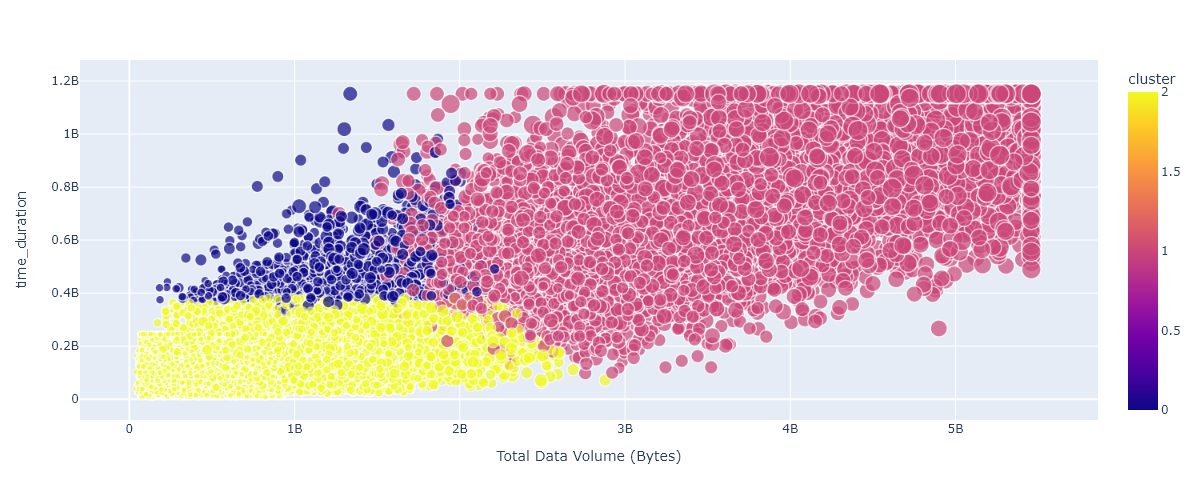

In [116]:
fig = px.scatter(user_engagements, x='Total Data Volume (Bytes)', y="time_duration", color='cluster', size='user_sessions')
# fig.show()
Image(pio.to_image(fig, format='png', width=1200)) #'user_sessions', 'time_duration', 'Total Data Volume (Bytes)'

3. minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.

In [117]:
C1 = user_engagements[user_engagements["cluster"]==0]
C1.describe()

,cluster,user_sessions,time_duration,Total Data Volume (Bytes)
count,1782.0,1782.000000,1.782000e+03,1.782000e+03
mean,0.0,3.279461,4.737764e+08,1.374458e+09
std,0.0,0.715917,1.005149e+08,3.874882e+08
min,0.0,2.000000,3.266064e+08,1.822832e+08
25%,0.0,3.000000,4.050353e+08,1.123586e+09
50%,0.0,3.000000,4.413609e+08,1.411471e+09
75%,0.0,4.000000,5.109586e+08,1.663161e+09
max,0.0,6.000000,1.151791e+09,2.259097e+09


In [118]:
C2 = user_engagements[user_engagements["cluster"]==1]
C2.describe()

,cluster,user_sessions,time_duration,Total Data Volume (Bytes)
count,10930.0,10930.000000,1.093000e+04,1.093000e+04
mean,1.0,8.032937,8.127697e+08,4.000102e+09
std,0.0,2.684191,3.020673e+08,1.312480e+09
min,1.0,3.000000,9.784126e+07,1.270622e+09
25%,1.0,5.000000,5.367885e+08,2.745697e+09
50%,1.0,8.000000,8.327308e+08,4.061291e+09
75%,1.0,11.000000,1.151791e+09,5.458784e+09
max,1.0,11.000000,1.151791e+09,5.458784e+09


In [119]:
C3 = user_engagements[user_engagements["cluster"]==2]
C3.describe()

,cluster,user_sessions,time_duration,Total Data Volume (Bytes)
count,22198.0,22198.000000,22198.0,2.219800e+04
mean,2.0,1.696189,149914784.0,8.334292e+08
std,0.0,0.827216,91124064.0,4.983802e+08
min,2.0,1.000000,7327634.0,3.792924e+07
25%,2.0,1.000000,85519440.0,4.559379e+08
50%,2.0,1.000000,136380224.0,7.555405e+08
75%,2.0,2.000000,214883792.0,1.140135e+09
max,2.0,5.000000,391546304.0,2.879792e+09


4. Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [120]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146887 entries, 0 to 146886
Data columns (total 55 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        146887 non-null  float32
 1   Bearer Id                         146887 non-null  float32
 2   Start                             146887 non-null  object 
 3   Start ms                          146887 non-null  float32
 4   End                               146887 non-null  object 
 5   End ms                            146887 non-null  float32
 6   IMSI                              146887 non-null  float32
 7   MSISDN/Number                     146887 non-null  float32
 8   IMEI                              146887 non-null  float32
 9   Last Location Name                146887 non-null  object 
 10  Avg RTT DL (ms)                   146887 non-null  float32
 11  Avg RTT UL (ms)                   146887 non-null  f

In [121]:
agg_user_traffic = clean_df.groupby(
    'MSISDN/Number').agg({'Gaming Data Volume (Bytes)': 'sum', 'Youtube Data Volume (Bytes)': 'sum', 'Netflix Data Volume (Bytes)': 'sum', 'Google Data Volume (Bytes)': 'sum', 'Email Data Volume (Bytes)': 'sum', 'Social Media Data Volume (Bytes)': 'sum', 'Other Data Volume (Bytes)': 'sum'})
agg_user_traffic.head()

,Gaming Data Volume (Bytes),Youtube Data Volume (Bytes),Netflix Data Volume (Bytes),Google Data Volume (Bytes),Email Data Volume (Bytes),Social Media Data Volume (Bytes),Other Data Volume (Bytes)
MSISDN/Number,,,,,,,
3.360100e+10,9.322088e+08,34056772.0,38402744.0,9723868.0,4639143.0,4892700.0,668280960.0
3.360100e+10,5.388277e+08,21333570.0,19353900.0,3443126.0,3205380.0,3195623.0,501693664.0
3.360101e+10,1.705924e+09,48510324.0,51143816.0,28178108.0,5590139.0,3192836.0,840084160.0
3.360101e+10,5.116358e+08,34347120.0,30315500.0,15263134.0,7848596.0,3792912.0,492372800.0
3.360101e+10,8.308255e+08,45324076.0,61105240.0,22220016.0,3574522.0,4552319.0,403090240.0


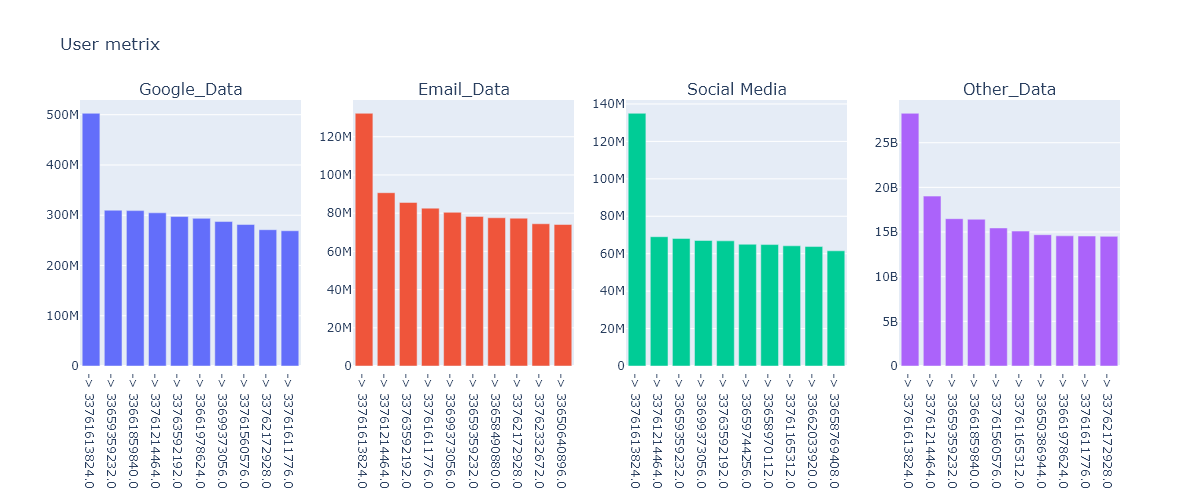

In [122]:
Gaming_Data = agg_user_traffic.nlargest(10, "Gaming Data Volume (Bytes)")['Gaming Data Volume (Bytes)']
Youtube_Data = agg_user_traffic.nlargest(10, "Youtube Data Volume (Bytes)")['Youtube Data Volume (Bytes)']
Netflix_Data = agg_user_traffic.nlargest(10, "Netflix Data Volume (Bytes)")['Netflix Data Volume (Bytes)']
Google_Data = agg_user_traffic.nlargest(10, "Google Data Volume (Bytes)")['Google Data Volume (Bytes)']
Email_Data = agg_user_traffic.nlargest(10, "Email Data Volume (Bytes)")['Email Data Volume (Bytes)']
Social_Media = agg_user_traffic.nlargest(10, "Social Media Data Volume (Bytes)")['Social Media Data Volume (Bytes)']
Other_Data = agg_user_traffic.nlargest(10, "Other Data Volume (Bytes)")['Other Data Volume (Bytes)']


mult_hist([Gaming_Data, Youtube_Data, Netflix_Data], 1,
          3, "User metrix", ["Gaming_Data", "Youtube_Data", "Netflix_Data"])
mult_hist([Google_Data, Email_Data, Social_Media, Other_Data], 1,
          4, "User metrix", [ "Google_Data", "Email_Data", "Social Media", "Other_Data"])

5. Plot the top 3 most used applications using appropriate charts.

In [123]:
top_3_apps = agg_user_traffic.sum()
top_3_apps

Gaming Data Volume (Bytes)          6.321320e+13
Youtube Data Volume (Bytes)         3.325813e+12
Netflix Data Volume (Bytes)         3.323940e+12
Google Data Volume (Bytes)          1.146890e+12
Email Data Volume (Bytes)           3.318305e+11
Social Media Data Volume (Bytes)    2.684706e+11
Other Data Volume (Bytes)           6.305373e+13
dtype: float32

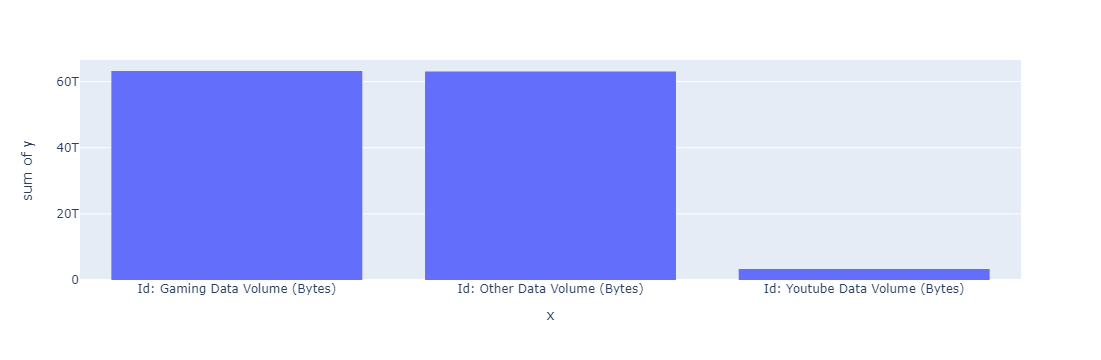

In [124]:
hist(top_3_apps.nlargest(3))

6. Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics.

- What is the optimized value of k(use elbow method for this)?
    -Interpret your findings.
    
**Distortion-** is the average of the euclidean squared distance from the centroid of the respective clusters.

**Inertia-** is the sum of squared distances of samples to their closest cluster centre.

In [125]:
df= clean_df

In [126]:
def choose_kmeans(df: pd.DataFrame, num: int):
    distortions = []
    inertias = []
    K = range(1, num)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        distortions.append(sum(
            np.min(cdist(df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
        inertias.append(kmeans.inertia_)
    return (distortions, inertias)

In [127]:
distortions, inertias = choose_kmeans(normalized_engagements, 15)

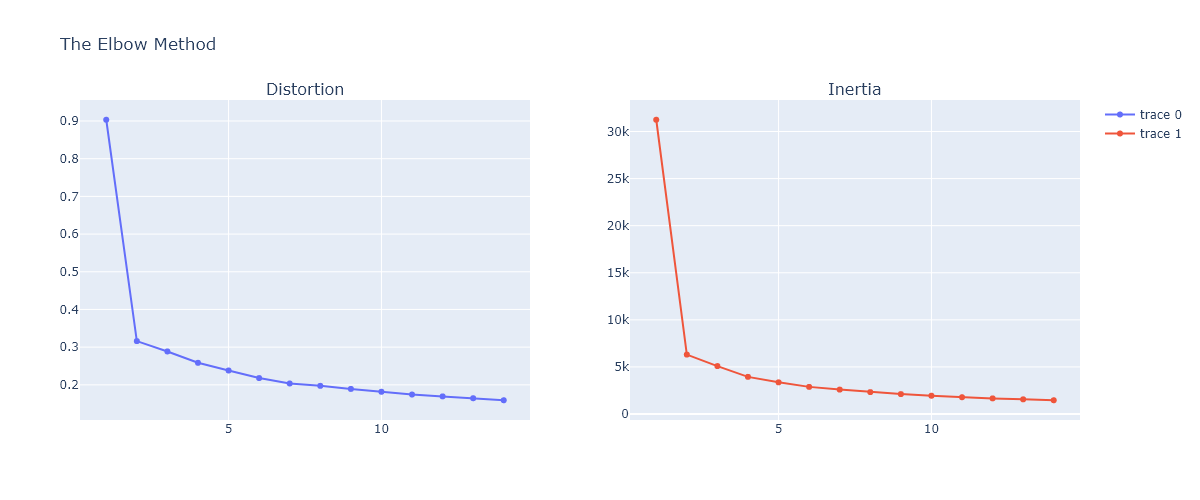

In [128]:
fig = make_subplots(
    rows=1, cols=2, subplot_titles=("Distortion", "Inertia")
)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=distortions), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(1, 15)), y=inertias), row=1, col=2)
fig.update_layout(title_text="The Elbow Method")
# fig.show(config=config)
Image(pio.to_image(fig, format='png', width=1200))

**Here:-** we can use 4 as an optimum number of cluster

In [129]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(normalized_engagements)
user_engagements["cluster"]= kmeans.labels_
user_engagements

,cluster,user_sessions,time_duration,Total Data Volume (Bytes)
MSISDN/Number,,,,
3.360100e+10,1,2.0,297951104.0,1.035550e+09
3.360100e+10,1,1.0,134969376.0,5.959665e+08
3.360101e+10,3,3.0,86982480.0,1.879732e+09
3.360101e+10,1,2.0,253983072.0,6.152172e+08
3.360101e+10,1,3.0,214760496.0,9.858016e+08
...,...,...,...,...
3.378996e+10,1,1.0,157069856.0,7.102876e+08
3.378997e+10,1,1.0,160461584.0,2.081231e+08
3.378998e+10,1,2.0,210390144.0,1.094693e+09


In [130]:
user_engagements.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34910 entries, 33601001472.0 to 337000045477888.0
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cluster                    34910 non-null  int32  
 1   user_sessions              34910 non-null  float64
 2   time_duration              34910 non-null  float32
 3   Total Data Volume (Bytes)  34910 non-null  float32
dtypes: float32(2), float64(1), int32(1)
memory usage: 818.2 KB


In [131]:
user_engagements['user_sessions']=user_engagements['user_sessions'].astype('float32')

In [132]:
user_engagements.to_csv('../data/TellCo_user_engagements2.csv')

In [133]:
import pickle

In [134]:
with open("../models/TellCo_user_engagement2.pkl", "wb") as f:
    pickle.dump(kmeans, f)